In [1]:
import joblib
import click
import json
import time
import os
import itertools
import collections.abc
from shutil import copy,SameFileError
from glob import glob

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pennylane as qml
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
# from qiskit_ibm_provider import IBMProvider

from quantum.Quantum import QuantumRegressor
from quantum.Evaluate import evaluate
from settings import ANSATZ_LIST, ENCODER_LIST
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import InconsistentVersionWarning

In [2]:
ANSATZs=[]
ENCODERs=[]
pairs=[]
results={}
for i in glob('../BSE_RUD_AL_test/5qubit/3_AL/*/*results.json'):
    pair = os.path.basename(i).replace('_results.json','')
    pairs.append(pair)
    an, en = pair.split('_')
    ANSATZs.append(an)
    ENCODERs.append(en)
    


ANSATZs=set(ANSATZs)
ENCODERs=set(ENCODERs)

In [3]:


# device='qiskit.aer'
# device_backend = FakeCairoV2()
# backend = AerSimulator.from_backend(device_backend)
# device = qml.device(device, wires=num_qubits, backend=backend, shots=shots)


device='qulacs.simulator'
num_qubits=5
device = qml.device(device, wires=num_qubits)


In [4]:
def circuit(features, parameters):
    #  builds the circuit with the given encoder and variational circuits.
    #  encoder and variational circuits must have only two required parameters, params/feats and wires
    for i in range(re_upload_depth):
        params = initial_parameters.reshape(re_upload_depth,-1)[i]
        
        encoder(features, wires=range(num_qubits))
        variational(params, wires=range(num_qubits))

    return qml.expval(qml.PauliZ(0))

In [5]:
def get_depth(enc,var,rud,features,parameters):
    circuit_gates=0
    circuit_depth=0
    for i in range(rud):
        params = initial_parameters.reshape(rud,-1)[i]
        
        encoder_specs=qml.specs(qml.QNode(encoder,device,expansion_strategy='device'))(features, wires=range(num_qubits))['resources']
        var_specs=qml.specs(qml.QNode(variational,device,expansion_strategy='device'))(params, wires=range(num_qubits))['resources']

        circuit_gates+=var_specs.num_gates + encoder_specs.num_gates
        circuit_depth+=var_specs.depth + encoder_specs.depth
    return circuit_gates,circuit_depth

In [6]:


# draw_encoder = qml.draw_mpl(qml.QNode(ENCODER_LIST['IQP'],device),level=3)
# draw_encoder(np.random.rand(num_qubits), range(num_qubits))

In [7]:
results={}
flat_results=[]
for d in [3, 5]:
    results[d]={}
    for a in ['AL','RUD']:
        results[d][a]={}
        if a=='AL':
            LAYERS=d
            re_upload_depth=1
        else:
            LAYERS=1
            re_upload_depth=d
            
        for p in pairs:
            results[d][a][p]={}
            depth_path = os.path.join("../BSE_RUD_AL_test/5qubit/",'_'.join((str(d),a)),p)
            if os.path.exists(depth_path):
                with open(os.path.join(depth_path,f'{p}_results.json'),'r') as f:
                    results_dict=json.load(f)
                
                
            ENCODER, ANSATZ = p.split('_')
            # print(ENCODER, ANSATZ)
            encoder = ENCODER_LIST[ENCODER]
            variational=ANSATZ_LIST[ANSATZ]
            variational.layers = LAYERS
            variational.set_wires(range(num_qubits))
     

            num_params = variational.num_params * re_upload_depth
            generator = np.random.default_rng(12958234)
            initial_parameters = generator.uniform(-np.pi, np.pi, num_params)
            feat = generator.uniform(-1, 1, num_qubits)
            
            qnode = qml.QNode(circuit, device)        
            circuit_specs=qml.specs(qnode)(feat,initial_parameters)['resources']

            circuit_gates,circuit_depth= get_depth(encoder,variational,re_upload_depth,feat,initial_parameters)
            # print(circuit_specs.num_gates,circuit_specs.depth)
            # print(circuit_gates,circuit_depth)
            
            # print(f"{p} AL_{LAYERS} RUD_{re_upload_depth}\n",circuit_specs)
            # qml.draw_mpl(qnode,level=1)(feat,initial_parameters)
            # plt.show()
            # print(variational.layers)
            # print()
            with open(os.path.join(depth_path,'model_log.csv'),'r') as f:
                # Create df
                timedf = pd.DataFrame(pd.to_datetime([i.split(',')[0] for i in f.readlines() if '[' in i], format='%a %b %d %H:%M:%S %Y'),columns=['Time'])
                # Get time between iterations and get the mean time
                timedf['Iter time']=[i.total_seconds() for i in timedf['Time'].diff()]
                

            results[d][a][p]={'MAE_train':results_dict['MAE_train'],'MAE_test':results_dict['MAE_test'],'num_gates':circuit_gates,'depth':circuit_depth,'mean_iter':timedf['Iter time'].mean()}
            if a=='AL':
                flat_results.append((d,1,p,results_dict['MAE_train'],results_dict['MAE_test'],circuit_gates,circuit_depth,timedf['Iter time'].mean()))
            else:
                flat_results.append((1,d,p,results_dict['MAE_train'],results_dict['MAE_test'],circuit_gates,circuit_depth,timedf['Iter time'].mean()))
            

/home/grierjones/miniconda3/envs/qml_min/lib/python3.12/site-packages/pennylane/gradients/gradient_transform.py:261: UserWarning: Attempted to compute the gradient of a tape with no trainable parameters. If this is unintended, please mark trainable parameters in accordance with the chosen auto differentiation framework, or via the 'tape.trainable_params' property.
  warnings.warn(_no_trainable_grad_warning)
/home/grierjones/miniconda3/envs/qml_min/lib/python3.12/site-packages/pennylane/gradients/gradient_transform.py:261: UserWarning: Attempted to compute the gradient of a tape with no trainable parameters. If this is unintended, please mark trainable parameters in accordance with the chosen auto differentiation framework, or via the 'tape.trainable_params' property.
  warnings.warn(_no_trainable_grad_warning)
/home/grierjones/miniconda3/envs/qml_min/lib/python3.12/site-packages/pennylane/gradients/gradient_transform.py:261: UserWarning: Attempted to compute the gradient of a tape with

In [8]:
for p in pairs:
    with open(f'../BSE-calc-test/5qubit/{p}/{p}_results.json','r') as f:
        og_results=json.load(f)
        
    ENCODER, ANSATZ = p.split('_')
    # print(ENCODER, ANSATZ)
    encoder = ENCODER_LIST[ENCODER]
    variational=ANSATZ_LIST[ANSATZ]

    LAYERS=1
    re_upload_depth=1
    variational.layers = LAYERS
    variational.set_wires(range(num_qubits))
    

    num_params = variational.num_params * re_upload_depth
    generator = np.random.default_rng(12958234)
    initial_parameters = generator.uniform(-np.pi, np.pi, num_params)
    feat = generator.uniform(-1, 1, num_qubits)
    
    qnode = qml.QNode(circuit, device)   

    # print(f"{p} AL_{LAYERS} RUD_{re_upload_depth}\n",circuit_specs)
    # qml.draw_mpl(qnode,level=1)(feat,initial_parameters)
    # plt.show()
    
    circuit_specs=qml.specs(qnode)(feat,initial_parameters)['resources']

    circuit_gates,circuit_depth= get_depth(encoder,variational,1,feat,initial_parameters)
    
    with open(os.path.join(f"../BSE-calc-test/5qubit/{p}",'model_log.csv'),'r') as f:
        # Create df
        timedf = pd.DataFrame(pd.to_datetime([i.split(',')[0] for i in f.readlines() if '[' in i], format='%a %b %d %H:%M:%S %Y'),columns=['Time'])
        # Get time between iterations and get the mean time
        timedf['Iter time']=[i.total_seconds() for i in timedf['Time'].diff()]
    
    flat_results.append((1,1,p,og_results['MAE_train'],og_results['MAE_test'],circuit_gates,circuit_depth,timedf['Iter time'].mean()))

/home/grierjones/miniconda3/envs/qml_min/lib/python3.12/site-packages/pennylane/gradients/gradient_transform.py:261: UserWarning: Attempted to compute the gradient of a tape with no trainable parameters. If this is unintended, please mark trainable parameters in accordance with the chosen auto differentiation framework, or via the 'tape.trainable_params' property.
  warnings.warn(_no_trainable_grad_warning)
/home/grierjones/miniconda3/envs/qml_min/lib/python3.12/site-packages/pennylane/gradients/gradient_transform.py:261: UserWarning: Attempted to compute the gradient of a tape with no trainable parameters. If this is unintended, please mark trainable parameters in accordance with the chosen auto differentiation framework, or via the 'tape.trainable_params' property.
  warnings.warn(_no_trainable_grad_warning)
/home/grierjones/miniconda3/envs/qml_min/lib/python3.12/site-packages/pennylane/gradients/gradient_transform.py:261: UserWarning: Attempted to compute the gradient of a tape with

In [9]:
df = pd.DataFrame(flat_results,columns=['AL','RUD','pairs','MAE Train','MAE Test','num_gates','depth','mean_iter'])

In [61]:
df.sort_values(by=['MAE Train','MAE Test'])

,AL,RUD,pairs,MAE Train,MAE Test,num_gates,depth,mean_iter,diff
43,5,1,M-M-CZ_Full-CRZ,18.902224,19.505385,180,106,457.629630,0.603161
48,1,5,A2_HWE-CZ,18.967704,19.975385,150,50,171.048048,1.007681
41,5,1,M-M-CZ_Full-CRX,18.997670,19.619027,180,106,439.459459,0.621357
32,5,1,IQP_Full-Pauli-CRX,19.030433,19.548400,260,91,208.381381,0.517968
33,5,1,A2_HWE-CZ,19.293560,19.801925,110,42,135.709710,0.508364
...,...,...,...,...,...,...,...,...,...
61,1,1,M-M-CZ_Efficient-CRX,37.939539,40.001707,64,34,175.008008,2.062168
69,1,1,M-M-CZ_Modified-Pauli-CRZ,37.939539,40.001707,50,20,48.482482,2.062168
71,1,1,M-M-CZ_Full-CRX,37.939539,40.001707,60,34,191.270270,2.062168
73,1,1,M-M-CZ_Full-CRZ,37.939539,40.001707,60,34,242.420420,2.062168


In [11]:
len(ENCODERs)//2

5

In [12]:
df['diff']=(df['MAE Train']-df['MAE Test']).abs()

In [13]:
df[(df['MAE Train']>0.9)&(df['MAE Train']>0.9)].sort_values(by=['MAE Train','MAE Test'])

,AL,RUD,pairs,MAE Train,MAE Test,num_gates,depth,mean_iter,diff
43,5,1,M-M-CZ_Full-CRZ,18.902224,19.505385,180,106,457.629630,0.603161
48,1,5,A2_HWE-CZ,18.967704,19.975385,150,50,171.048048,1.007681
41,5,1,M-M-CZ_Full-CRX,18.997670,19.619027,180,106,439.459459,0.621357
32,5,1,IQP_Full-Pauli-CRX,19.030433,19.548400,260,91,208.381381,0.517968
33,5,1,A2_HWE-CZ,19.293560,19.801925,110,42,135.709710,0.508364
...,...,...,...,...,...,...,...,...,...
61,1,1,M-M-CZ_Efficient-CRX,37.939539,40.001707,64,34,175.008008,2.062168
69,1,1,M-M-CZ_Modified-Pauli-CRZ,37.939539,40.001707,50,20,48.482482,2.062168
71,1,1,M-M-CZ_Full-CRX,37.939539,40.001707,60,34,191.270270,2.062168
73,1,1,M-M-CZ_Full-CRZ,37.939539,40.001707,60,34,242.420420,2.062168


In [14]:
median_Train,median_Test=np.median(df[['MAE Train',"MAE Test"]].values,axis=0)

182.7177177177177

In [15]:
palette=sns.color_palette('Paired',4)

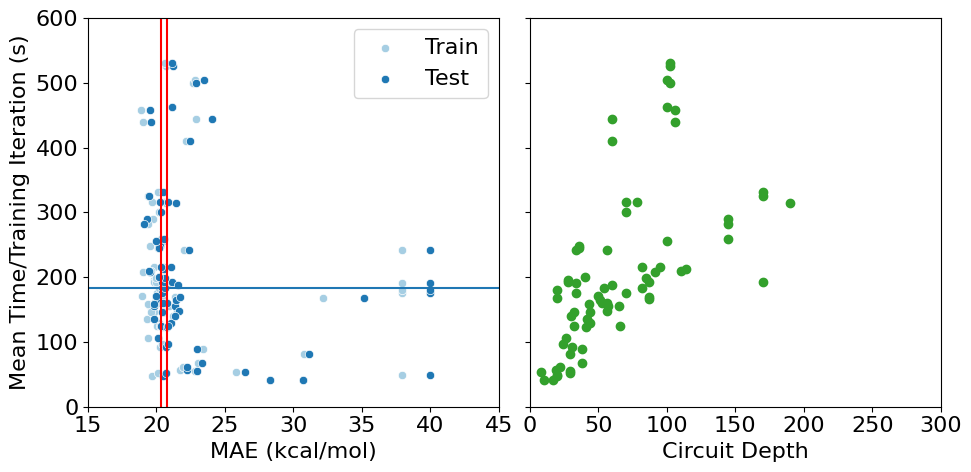

In [122]:
SMALL_SIZE = 8
MEDIUM_SIZE = 16
BIGGER_SIZE = 12

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

fig, ax = plt.subplots(1,2,sharey=True,figsize=(10,5))
sns.scatterplot(df,x='MAE Train',y='mean_iter',label='Train',ax=ax[0],color=palette[0])
sns.scatterplot(df,x='MAE Test',y='mean_iter',label='Test',ax=ax[0],color=palette[1])
# plt.hlines(df.describe().loc['mean','mean_iter'],0,50)
ax[0].hlines(np.median(df['mean_iter']),0,50)
ax[0].vlines(median_Train,0,700,color='r')
ax[0].vlines(median_Test,0,700,color='r')

ax[0].set_xlim(15,45)
ax[0].set_ylim(0,600)
ax[0].set_ylabel('Mean Time/Training Iteration (s)')
ax[0].set_xlabel('MAE (kcal/mol)')
ax[0].legend()

ax[1].scatter(df['depth'],df['mean_iter'],color=palette[3])
ax[1].set_xlim(0,300)
ax[1].set_xlabel('Circuit Depth')
plt.tight_layout()
# plt.savefig('BSE5_circuitdepth_MAE_vs_iterationtime.png',dpi=300,bbox_inches='tight')
plt.show()

In [16]:
palette

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313)]

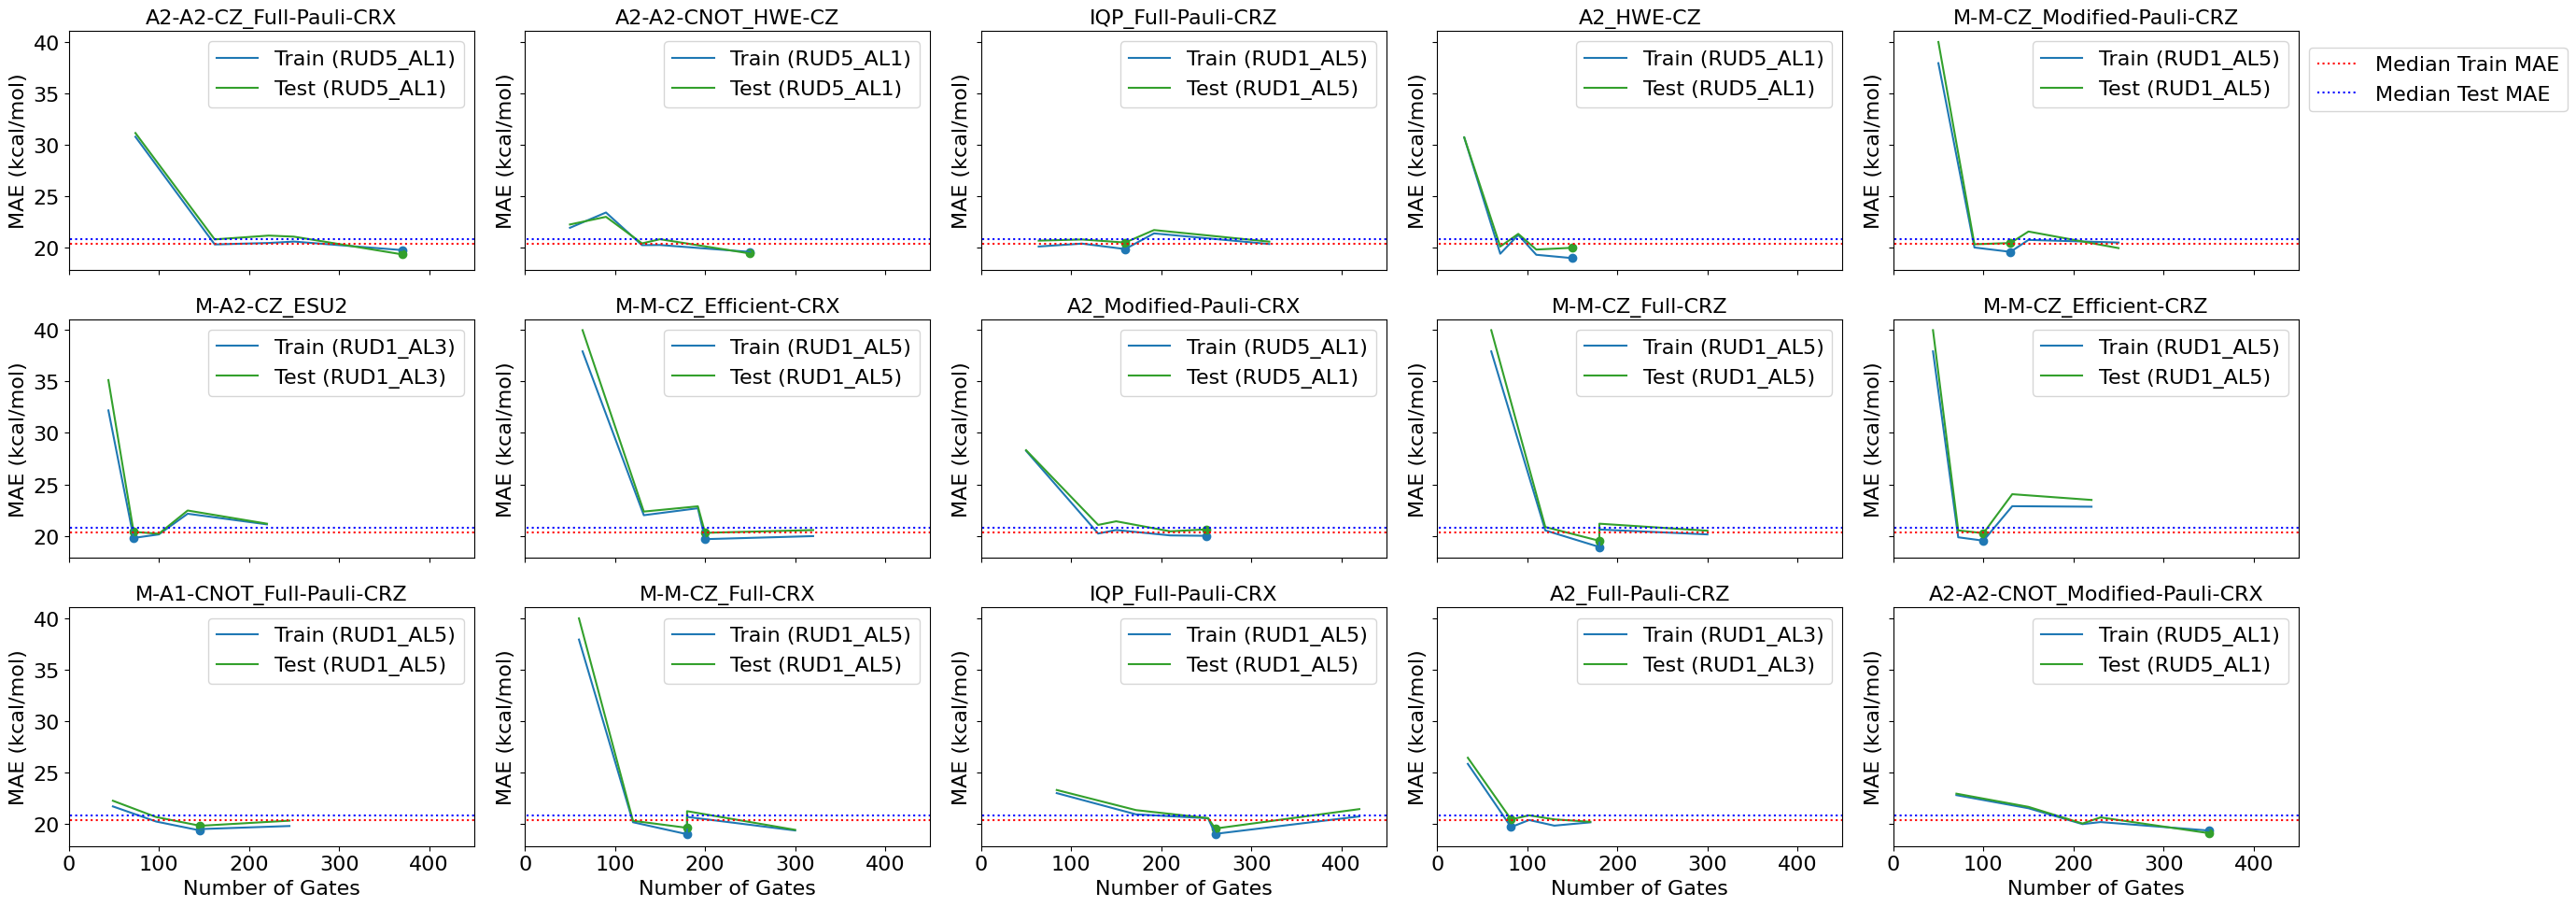

In [17]:
SMALL_SIZE = 8
MEDIUM_SIZE = 16
BIGGER_SIZE = 12

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

fig,ax=plt.subplots(3,len(pairs)//3,sharey=True,sharex=True,figsize=(25,10))


for idxe,p in enumerate(pairs):
    
        pairdf=df[df['pairs']==p].sort_values(by=["num_gates"])
        min=pairdf.sort_values(by=['MAE Train',"MAE Test"]).iloc[0]
        ax[idxe%3,idxe%5].plot(pairdf['num_gates'],pairdf['MAE Train'],label=f'Train'+" ("+'_'.join((f"RUD{min['RUD']}",f"AL{min['AL']}"))+f')',color=palette[1])
        ax[idxe%3,idxe%5].plot(pairdf['num_gates'],pairdf['MAE Test'],label=f'Test'+" ("+'_'.join((f"RUD{min['RUD']}",f"AL{min['AL']}"))+f')',color=palette[3])
        ax[idxe%3,idxe%5].scatter(min['num_gates'],min['MAE Train'],color=palette[1])
        ax[idxe%3,idxe%5].scatter(min['num_gates'],min['MAE Test'],color=palette[3])
        ax[idxe%3,idxe%5].hlines(median_Train,-10,500,color='r',linestyles=':',label="Median Train MAE")
        ax[idxe%3,idxe%5].hlines(median_Test,-10,500,color='b',linestyles=':',label="Median Test MAE")
        ax[idxe%3,idxe%5].legend(ax[idxe%3,idxe%5].get_legend_handles_labels()[0][:-2],ax[idxe%3,idxe%5].get_legend_handles_labels()[1][:-2],loc=1)
        ax[idxe%3,idxe%5].set_ylabel('MAE (kcal/mol)')
        ax[idxe%3,idxe%5].set_xlim(0,450)
        ax[idxe%3,idxe%5].set_title(p)

        if (idxe%3)==2:
            ax[idxe%3,idxe%5].set_xlabel('Number of Gates')

fig.legend(ax[-1,-1].get_legend_handles_labels()[0][-2:],ax[-1,-1].get_legend_handles_labels()[1][-2:], loc='right', bbox_to_anchor=(1.11, 0.9))        
plt.tight_layout()        
plt.savefig('BSE5_numgates_vs_MAE.png',dpi=300,bbox_inches='tight')
plt.show()

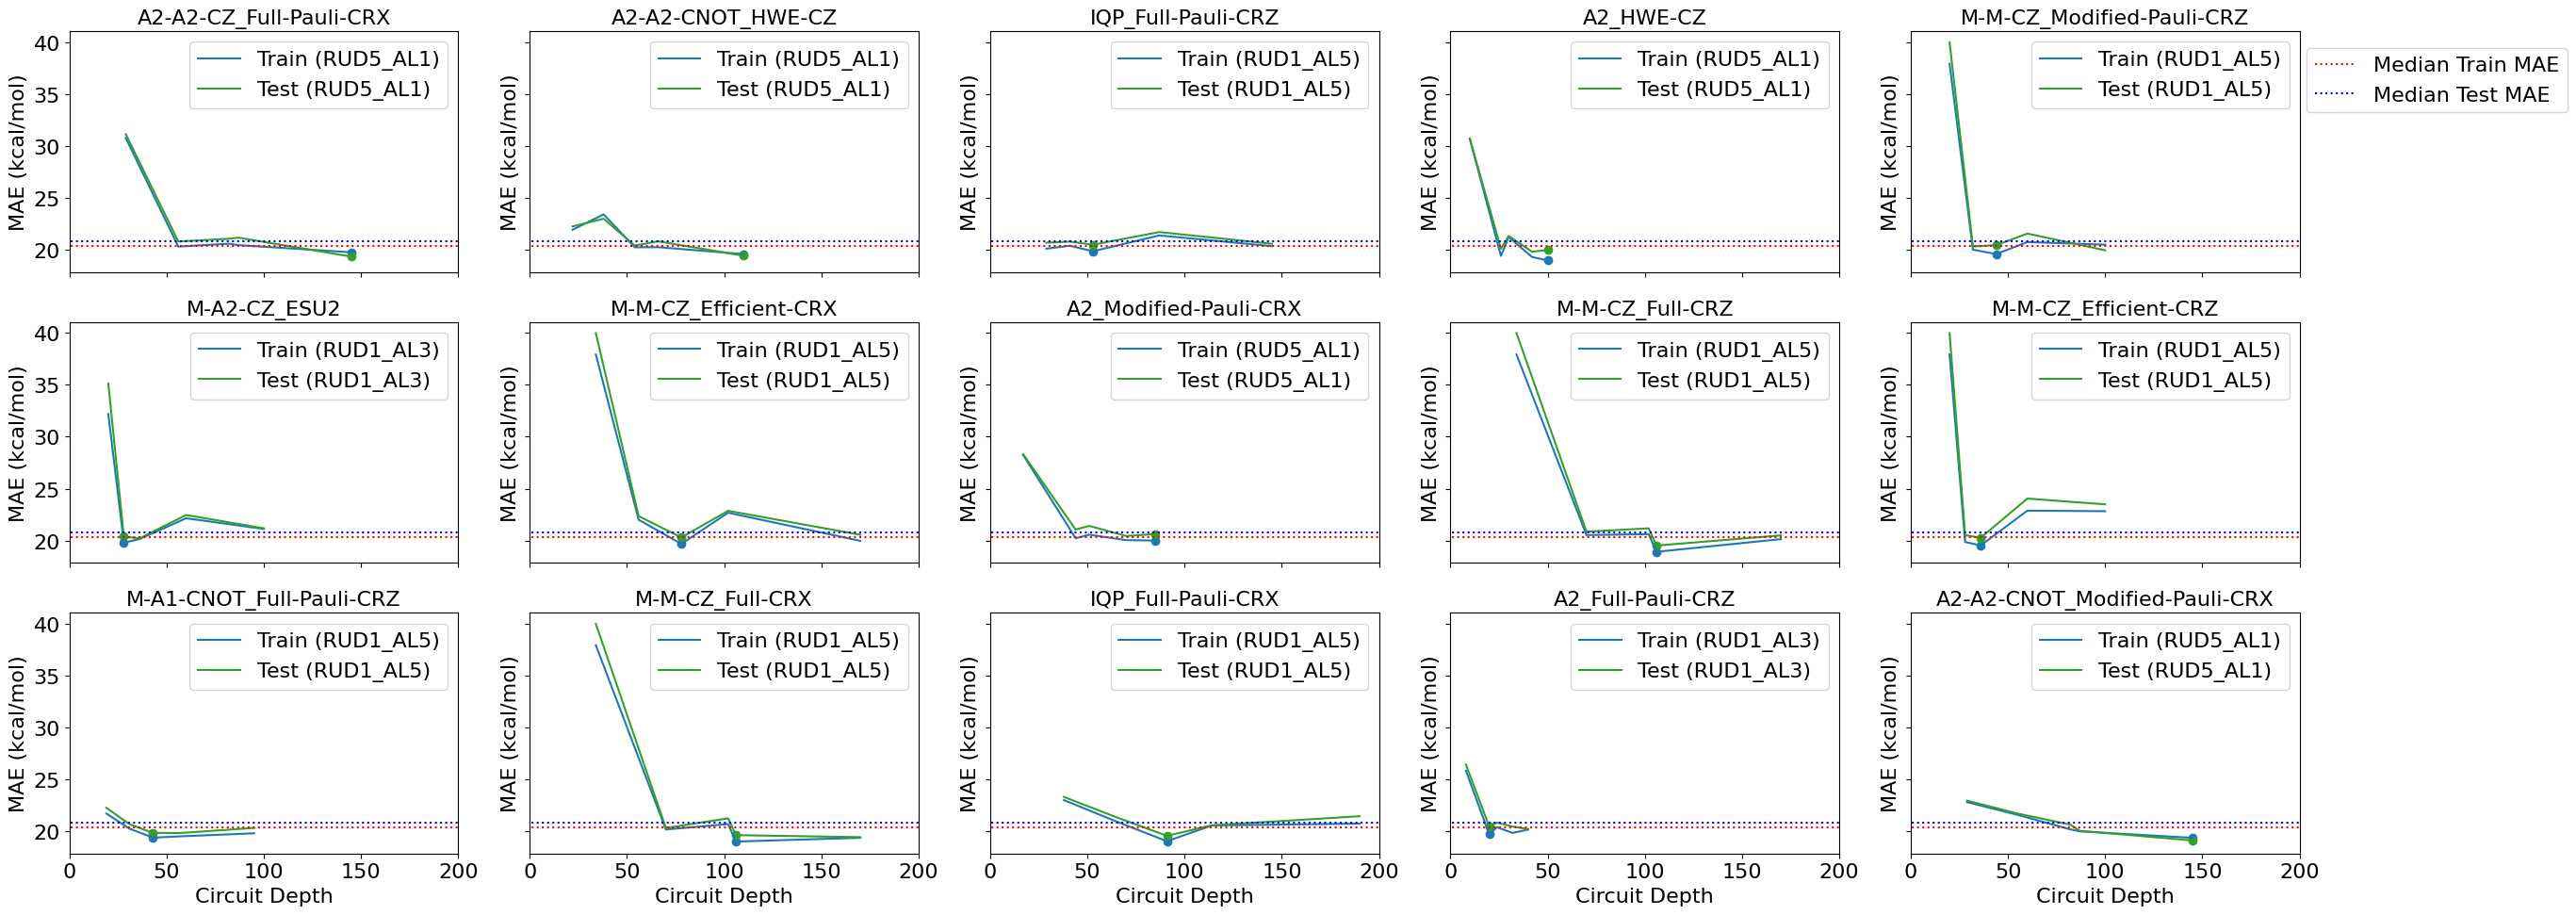

In [18]:
SMALL_SIZE = 8
MEDIUM_SIZE = 16
BIGGER_SIZE = 12

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

fig,ax=plt.subplots(3,len(pairs)//3,sharey=True,sharex=True,figsize=(25,10))


for idxe,p in enumerate(pairs):
    
        pairdf=df[df['pairs']==p].sort_values(by=["depth"])
        min=pairdf.sort_values(by=['MAE Train',"MAE Test"]).iloc[0]
        ax[idxe%3,idxe%5].plot(pairdf['depth'],pairdf['MAE Train'],label=f'Train'+" ("+'_'.join((f"RUD{min['RUD']}",f"AL{min['AL']}"))+f')',color=palette[1])
        ax[idxe%3,idxe%5].plot(pairdf['depth'],pairdf['MAE Test'],label=f'Test'+" ("+'_'.join((f"RUD{min['RUD']}",f"AL{min['AL']}"))+f')',color=palette[3])
        ax[idxe%3,idxe%5].scatter(min['depth'],min['MAE Train'],color=palette[1])
        ax[idxe%3,idxe%5].scatter(min['depth'],min['MAE Test'],color=palette[3])
        ax[idxe%3,idxe%5].hlines(median_Train,-10,500,color='r',linestyles=':',label="Median Train MAE")
        ax[idxe%3,idxe%5].hlines(median_Test,-10,500,color='b',linestyles=':',label="Median Test MAE")
        ax[idxe%3,idxe%5].legend(ax[idxe%3,idxe%5].get_legend_handles_labels()[0][:-2],ax[idxe%3,idxe%5].get_legend_handles_labels()[1][:-2],loc=1)
        ax[idxe%3,idxe%5].set_ylabel('MAE (kcal/mol)')
        ax[idxe%3,idxe%5].set_xlim(0,200)
        ax[idxe%3,idxe%5].set_title(p)

        if (idxe%3)==2:
            ax[idxe%3,idxe%5].set_xlabel('Circuit Depth')

fig.legend(ax[-1,-1].get_legend_handles_labels()[0][-2:],ax[-1,-1].get_legend_handles_labels()[1][-2:], loc='right', bbox_to_anchor=(1.1, 0.9))                
plt.tight_layout()        
plt.savefig('BSE5_circuitdepth_vs_MAE.png',dpi=300,bbox_inches='tight')
plt.show()

In [19]:
# SMALL_SIZE = 8
# MEDIUM_SIZE = 14
# BIGGER_SIZE = 12

# plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

# fig,ax=plt.subplots(2,len(ENCODERs)//2,sharey=True,sharex=True,figsize=(25,10))

# for idxa,a in enumerate(ANSATZs):
#     for idxe,e in enumerate(ENCODERs):
#         if '_'.join((a,e)) in pairs:
#             pairdf=df[df['pairs']=='_'.join((a,e))].sort_values(by=["num_gates"])
#             min=pairdf.sort_values(by=['MAE Train',"MAE Test"]).iloc[0]
#             ax[idxe%2,idxe%5].plot(pairdf['num_gates'],pairdf['MAE Train'],label=f'Train {a}'+" ("+'_'.join((f"RUD{min['RUD']}",f"AL{min['AL']}"))+f')')
#             ax[idxe%2,idxe%5].plot(pairdf['num_gates'],pairdf['MAE Test'],label=f'Test {a}'+" ("+'_'.join((f"RUD{min['RUD']}",f"AL{min['AL']}"))+f')')
#             ax[idxe%2,idxe%5].scatter(min['num_gates'],min['MAE Train'])
#             ax[idxe%2,idxe%5].scatter(min['num_gates'],min['MAE Test'])
#             ax[idxe%2,idxe%5].hlines(median_Train,-10,500,color='r',linestyles=':',label="Median Train MAE")
#             ax[idxe%2,idxe%5].hlines(median_Test,-10,500,color='b',linestyles=':',label="Median Test MAE")
#             ax[idxe%2,idxe%5].legend(loc=2)
#             ax[idxe%2,idxe%5].set_ylabel(e)
#             ax[idxe%2,idxe%5].set_xlim(0,450)

#             if (idxe%2)==1:
#                 ax[idxe%2,idxe%5].set_xlabel('Number of Gates')
    
        
# plt.tight_layout()        
# plt.show()

In [20]:
# fig,ax=plt.subplots(2,len(ENCODERs)//2,sharey=True,sharex=True,figsize=(25,10))

# for idxa,a in enumerate(ANSATZs):
#     for idxe,e in enumerate(ENCODERs):
#         if '_'.join((a,e)) in pairs:
#             pairdf=df[df['pairs']=='_'.join((a,e))].sort_values(by=["depth"])
#             min=pairdf.sort_values(by=['MAE Train',"MAE Test"]).iloc[0]
#             ax[idxe%2,idxe%5].plot(pairdf['depth'],pairdf['MAE Train'],label=f'Train {a}'+" ("+'_'.join((f"RUD{min['RUD']}",f"AL{min['AL']}"))+f')')
#             ax[idxe%2,idxe%5].plot(pairdf['depth'],pairdf['MAE Test'],label=f'Test {a}'+" ("+'_'.join((f"RUD{min['RUD']}",f"AL{min['AL']}"))+f')')
#             ax[idxe%2,idxe%5].scatter(min['depth'],min['MAE Train'])
#             ax[idxe%2,idxe%5].scatter(min['depth'],min['MAE Test'])
#             ax[idxe%2,idxe%5].hlines(median_Train,-10,300,color='r',linestyles=':',label="Median Train MAE")
#             ax[idxe%2,idxe%5].hlines(median_Test,-10,300,color='b',linestyles=':',label="Median Test MAE")
#             ax[idxe%2,idxe%5].legend(loc=2)
#             ax[idxe%2,idxe%5].set_ylabel(e)
#             ax[idxe%2,idxe%5].set_xlim(0,200)

#             if (idxe%2)==1:
#                 ax[idxe%2,idxe%5].set_xlabel('Circuit Depth')
    
        
# plt.tight_layout()        
# plt.show()

In [21]:
# for p in pairs:
#     sns.lineplot(df[df['pairs']==p].melt(id_vars=['num_gates','depth'],value_vars=['MAE Train','MAE Test']),x='depth',y='value',hue='variable')
#     plt.show()

In [22]:
layerdf=df.melt(id_vars=['AL','RUD'],value_vars=['MAE Train','MAE Test'])

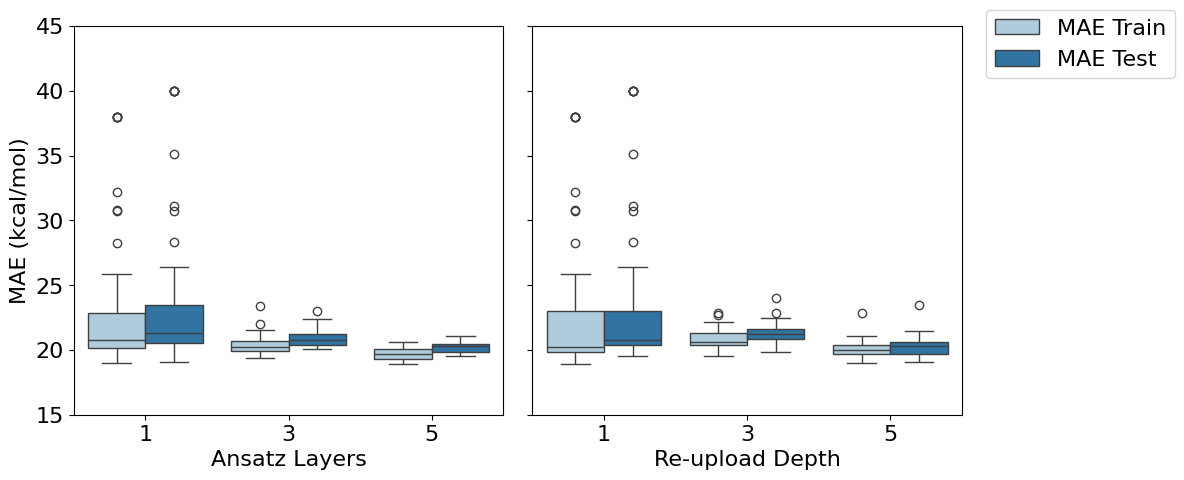

In [23]:
fig,ax=plt.subplots(1,2,sharey=True,figsize=(10,5))
sns.boxplot(data=layerdf,y='value',hue='variable',x='AL',ax=ax[0],palette=sns.color_palette('Paired',2))
sns.boxplot(data=layerdf,y='value',hue='variable',x='RUD',ax=ax[1],palette=sns.color_palette('Paired',2))
# ax[0].hlines(median_Train,-10,500,color='r',linestyles=':',label="Median Train MAE")
# ax[0].hlines(median_Test,-10,500,color='b',linestyles=':',label="Median Test MAE")
# ax[1].hlines(median_Train,-10,500,color='r',linestyles=':',label="Median Train MAE")
# ax[1].hlines(median_Test,-10,500,color='b',linestyles=':',label="Median Test MAE")
ax[0].legend().set_visible(False)
ax[1].legend().set_visible(False)
ax[0].set_xlim(-0.5,2.5)
ax[1].set_xlim(-0.5,2.5)
ax[0].set_ylim(15,45)
ax[1].set_ylim(15,45)
ax[0].set_ylabel('MAE (kcal/mol)')
ax[0].set_xlabel('Ansatz Layers')
ax[1].set_xlabel('Re-upload Depth')
fig.legend(ax[1].get_legend_handles_labels()[0],ax[1].get_legend_handles_labels()[1], loc='right', bbox_to_anchor=(1.2, 0.9))                
plt.tight_layout()
plt.savefig('BSE5_MAE_vs_layers.png',dpi=300,bbox_inches='tight')
plt.show()

In [24]:
pairs

['A2-A2-CZ_Full-Pauli-CRX',
 'M-M-CZ_Efficient-CRX',
 'IQP_Full-Pauli-CRX',
 'A2_HWE-CZ',
 'M-M-CZ_Efficient-CRZ',
 'M-A1-CNOT_Full-Pauli-CRZ',
 'A2-A2-CNOT_HWE-CZ',
 'A2_Modified-Pauli-CRX',
 'A2_Full-Pauli-CRZ',
 'M-M-CZ_Modified-Pauli-CRZ',
 'M-A2-CZ_ESU2',
 'M-M-CZ_Full-CRX',
 'IQP_Full-Pauli-CRZ',
 'M-M-CZ_Full-CRZ',
 'A2-A2-CNOT_Modified-Pauli-CRX']

In [25]:
glob("../BSE_RUD_AL_test/5qubit/*/*/model_log.csv")[0]

'../BSE_RUD_AL_test/5qubit/5_RUD/A2-A2-CZ_Full-Pauli-CRX/model_log.csv'

In [26]:
df

,AL,RUD,pairs,MAE Train,MAE Test,num_gates,depth,mean_iter,diff
0,3,1,A2-A2-CZ_Full-Pauli-CRX,20.302682,20.791633,162,56,160.315315,0.488952
1,3,1,M-M-CZ_Efficient-CRX,21.995181,22.349362,132,56,242.019019,0.354181
2,3,1,IQP_Full-Pauli-CRX,20.929794,21.343205,172,65,154.927928,0.413411
3,3,1,A2_HWE-CZ,19.395952,20.094300,70,26,106.581582,0.698349
4,3,1,M-M-CZ_Efficient-CRZ,19.846704,20.516297,72,28,194.920921,0.669593
...,...,...,...,...,...,...,...,...,...
70,1,1,M-A2-CZ_ESU2,32.194861,35.145485,44,20,167.221221,2.950623
71,1,1,M-M-CZ_Full-CRX,37.939539,40.001707,60,34,191.270270,2.062168
72,1,1,IQP_Full-Pauli-CRZ,20.098992,20.670905,64,29,52.429429,0.571913
73,1,1,M-M-CZ_Full-CRZ,37.939539,40.001707,60,34,242.420420,2.062168
